This notebook is for the WIP paper tentatively titled Response Topography Modulates Response-Withholding Performance in Mice by Daniels et al (in prep).  
*Note: A draft of this paper is not yet available.*   
*Note: Some of this code is back from when I first transitioned from Matlab to Python; thus best practices are not always adhered too; I apologize in advance*

The goal of this study was to **determine the ideal parameters for training mice in a response withholding task under varying levels of motivation**. 
1. To that end, mice were divided into two different groups: initiation/first response as nose-poke (NP) or  lever-press. (LP) 
2. Both groups of mice were then trained in sequence:  differential-reinforcement-of-low rates (DRL) and then a fixed-minimum interval (FMI) schedule of reinforcement. 
3. In each schedule two intervals were explored: 3 s and 6 s; along with two levels of food deprivation. 
4. Once training stabilized in each interval mice were given a pre-feeding challenge (1 hour of food access immediately prior to the experimental session). 

The following data were collected:
1. Latencies: the time to the first response 
2. Inter-response interval (IRT): the time between the first response and the second


Data were originally processed in Matlab (for historical reasons). Rather than repeat such processing, the .mat files and .m files can be found in the Github for this project. The remainder of the processing and analysis needed will be conducted in this Jupyter Notebook unless otherwise specified. 

Specifically,
1. Latencies will be analyzed via an empirical analysis. 
2. IRTs will be analyzed by fitting the Temporal Regulation model (TR: see Watterson et al., 2015) and an extended version of the TR model, which I refer to as TRe. 

Briefly, the TR model assumes that mice fluctuate in and out of two engagement states and that there is a timing state whose IRTs can be described by a gamma distribution and a non-timing state whose IRTs can be described by an exponential distribution. Alternatively, the TRe model assumes that mice fluctuate in and out of three engagement states: the timing state, a burst responding state, and a lapse state. Whereas the timing state can be described as before; the burst responding and lapse states are both described by exponential distributions but with different means. The mean of the burst responding state must be shorter than the mean of the lapse responding state. 

Without belaboring any points or giving away any details crucial for the analysis, let's pull in the packages we will need. 

In [66]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import gamma
from scipy.stats import expon
import os

First we will import the database in storing all IRTs from the experiment and parameter estimates following TR model fitting.

In [67]:
location = "E:\\Dropbox\\2 All of Carter's Stuff\\Carter Local\\ASU Research Projects\\Mutant Mice Projects\\Topography Project\\New Analysis (based on Watterson et al. 2015)\\IRTs_TRmodel1.mat"
matlab_database = spio.loadmat(location, squeeze_me = True)
matlab_names = spio.whosmat(location)
for names in matlab_names:
    print(names)

('A', (1, 1), 'double')
('DRL_exp1', (3828, 19), 'double')
('DRL_exp1_PF', (493, 19), 'double')
('DRL_exp2', (6211, 19), 'double')
('DRL_exp2_PF', (828, 19), 'double')
('FI', (1, 1), 'double')
('FMI_exp1', (1699, 19), 'double')
('FMI_exp1_PF', (276, 19), 'double')
('FMI_exp2', (2178, 19), 'double')
('FMI_exp2_PF', (284, 19), 'double')
('IRTs', (3215, 1), 'double')
('Intervals', (2178, 1), 'double')
('LL_out', (1, 1), 'double')
('LLcollector', (1, 16), 'double')
('LLcollector_DRL_e1_B3', (1, 16), 'double')
('LLcollector_DRL_e1_B3_TRe', (1, 16), 'double')
('LLcollector_DRL_e1_B6', (1, 16), 'double')
('LLcollector_DRL_e1_B6_TRe', (1, 16), 'double')
('LLcollector_DRL_e1_PF3', (1, 16), 'double')
('LLcollector_DRL_e1_PF3_TRe', (1, 16), 'double')
('LLcollector_DRL_e1_PF6', (1, 16), 'double')
('LLcollector_DRL_e1_PF6_TRe', (1, 16), 'double')
('LLcollector_DRL_e2_B3', (1, 16), 'double')
('LLcollector_DRL_e2_B3_TRe', (1, 16), 'double')
('LLcollector_DRL_e2_B6', (1, 16), 'double')
('LLcollector_D

As you can see, this matlab database contains a lot of information. For our first analysis, which is a visualization of model fit we need (1) IRTs for each condition and (2) parameter estimates in each condition. 

IRTs can be found in variables titled Schedule_expX?_PF where Schedule = DRL or FMI X = 1 or 2 and the baseline condition has nothing else but the pre-feeding conditions has _PF.

Parameter estimates can be found in pcollector_Schedule_expX where Schedule and X are as in above for the baseline condition and parameter estimates for the pre-feeding condition are as follows pcollector_Schedule_expX?_PF.

Let's focusing on constructing obtained probability functions. We will start with DRL and move our away through the waiting requirements,schedules, and feeding conditions until we finish with FMI 6-s.

Note that because we will do some model selection we are going to gather counts of the amount of data. 

In [68]:
##DRL Data. Note that due to a chamber malfunction subject 1 does not have reliable pre-feeding for 6-s
#Baseline
data_counts = np.zeros([2,16])
E1_DRL_B = matlab_database['DRL_exp1'] #Note that the last column indicates the waiting requirement
E1_DRL_B3 = E1_DRL_B[E1_DRL_B[:,-1]==3,2:-1] #Select data only for 3 s condition, dropping the waiting requirement
databins = np.linspace(0,15,31)
E1_DRL_B_3hist = np.zeros((databins.shape[0]-1,16)) 
for i in range(0,16): 
    data = E1_DRL_B3[:,i][~np.isnan(E1_DRL_B3[:,i])]
    data_counts[0,i] = data_counts[0,i] + np.count_nonzero(E1_DRL_B3[:,i][~np.isnan(E1_DRL_B3[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_DRL_B_3hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
E1_DRL_B6 = E1_DRL_B[E1_DRL_B[:,-1]==6,2:-1] #Select data only for 6 s condition, dropping needless columns
E1_DRL_B_6hist = np.zeros((databins.shape[0]-1,16)) #Empty array
for i in range(0,15):
    data = E1_DRL_B6[:,i][~np.isnan(E1_DRL_B6[:,i])]
    data_counts[0,i] = data_counts[0,i] + np.count_nonzero(E1_DRL_B6[:,i][~np.isnan(E1_DRL_B6[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_DRL_B_6hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
#Pre-feeding
E1_DRL_PF = matlab_database['DRL_exp1_PF'] #Note that the last column indicates the waiting requirement
E1_DRL_PF3 = E1_DRL_PF[E1_DRL_PF[:,-1]==3,2:-1] #Select data only for 3 s condition, dropping the waiting requirement
E1_DRL_PF_3hist = np.zeros((databins.shape[0]-1,16)) 
for i in range(0,16): 
    data = E1_DRL_PF3[:,i][~np.isnan(E1_DRL_PF3[:,i])]
    data_counts[0,i] = data_counts[0,i] + np.count_nonzero(E1_DRL_PF3[:,i][~np.isnan(E1_DRL_PF3[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_DRL_PF_3hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
E1_DRL_PF6 = E1_DRL_PF[E1_DRL_PF[:,-1]==6,2:-1] #Select data only for 6 s condition, dropping needless columns
E1_DRL_PF_6hist = np.zeros((databins.shape[0]-1,16)) #Empty array
for i in range(0,15):
    data = E1_DRL_PF6[:,i][~np.isnan(E1_DRL_PF6[:,i])]
    data_counts[0,i] = data_counts[0,i] + np.count_nonzero(E1_DRL_PF6[:,i][~np.isnan(E1_DRL_PF6[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_DRL_PF_6hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
#FMI Data. Note that Subject 16 died during the FMI condition and thus has no data
#Baseline
E1_FMI_B = matlab_database['FMI_exp1'] #Note that the last column indicates the waiting requirement
E1_FMI_B3 = E1_FMI_B[E1_FMI_B[:,-1]==3,2:-1] #Select data only for 3 s condition, dropping needless columns
E1_FMI_B_3hist = np.zeros((databins.shape[0]-1,15)) 
for i in range(0,15): 
    data = E1_FMI_B3[:,i][~np.isnan(E1_FMI_B3[:,i])]
    data_counts[1,i] = data_counts[1,i] + np.count_nonzero(E1_FMI_B3[:,i][~np.isnan(E1_FMI_B3[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_FMI_B_3hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
E1_FMI_B6 = E1_FMI_B[E1_FMI_B[:,-1]==6,2:-1] #Select data only for 6 s condition, dropping needless columns
E1_FMI_B_6hist = np.zeros((databins.shape[0]-1,15)) #Empty array
for i in range(0,15):
    data = E1_FMI_B6[:,i][~np.isnan(E1_FMI_B6[:,i])]
    data_counts[1,i] = data_counts[1,i] + np.count_nonzero(E1_FMI_B6[:,i][~np.isnan(E1_FMI_B6[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_FMI_B_6hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
#Pre-feeding
E1_FMI_PF = matlab_database['FMI_exp1_PF'] #Note that the last column indicates the waiting requirement
E1_FMI_PF3 = E1_FMI_PF[E1_FMI_PF[:,-1]==3,2:-1] #Select data only for 3 s condition, dropping needless columns
E1_FMI_PF_3hist = np.zeros((databins.shape[0]-1,15)) 
for i in range(0,15): 
    data = E1_FMI_PF3[:,i][~np.isnan(E1_FMI_PF3[:,i])]
    data_counts[1,i] = data_counts[1,i] + np.count_nonzero(E1_FMI_PF3[:,i][~np.isnan(E1_FMI_PF3[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_FMI_PF_3hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))
    
E1_FMI_PF6 = E1_FMI_PF[E1_FMI_PF[:,-1]==6,2:-1] #Select data only for 6 s condition, dropping needless columns
E1_FMI_PF_6hist = np.zeros((databins.shape[0]-1,15)) #Empty array
for i in range(0,15):
    data = E1_FMI_PF6[:,i][~np.isnan(E1_FMI_PF6[:,i])]
    data_counts[1,i] = data_counts[1,i] + np.count_nonzero(E1_FMI_PF6[:,i][~np.isnan(E1_FMI_PF6[:,i])])
    output = np.histogram(data,bins=databins, density=False)
    E1_FMI_PF_6hist[:,i] = np.divide(output[:][0],np.sum(output[:][0]))


Now that the data has been sorted we can confirm the pdfs of each animal in the next cell. Note that subject 16 was dropped from analysis because the subject died before the experiment could be completed. 

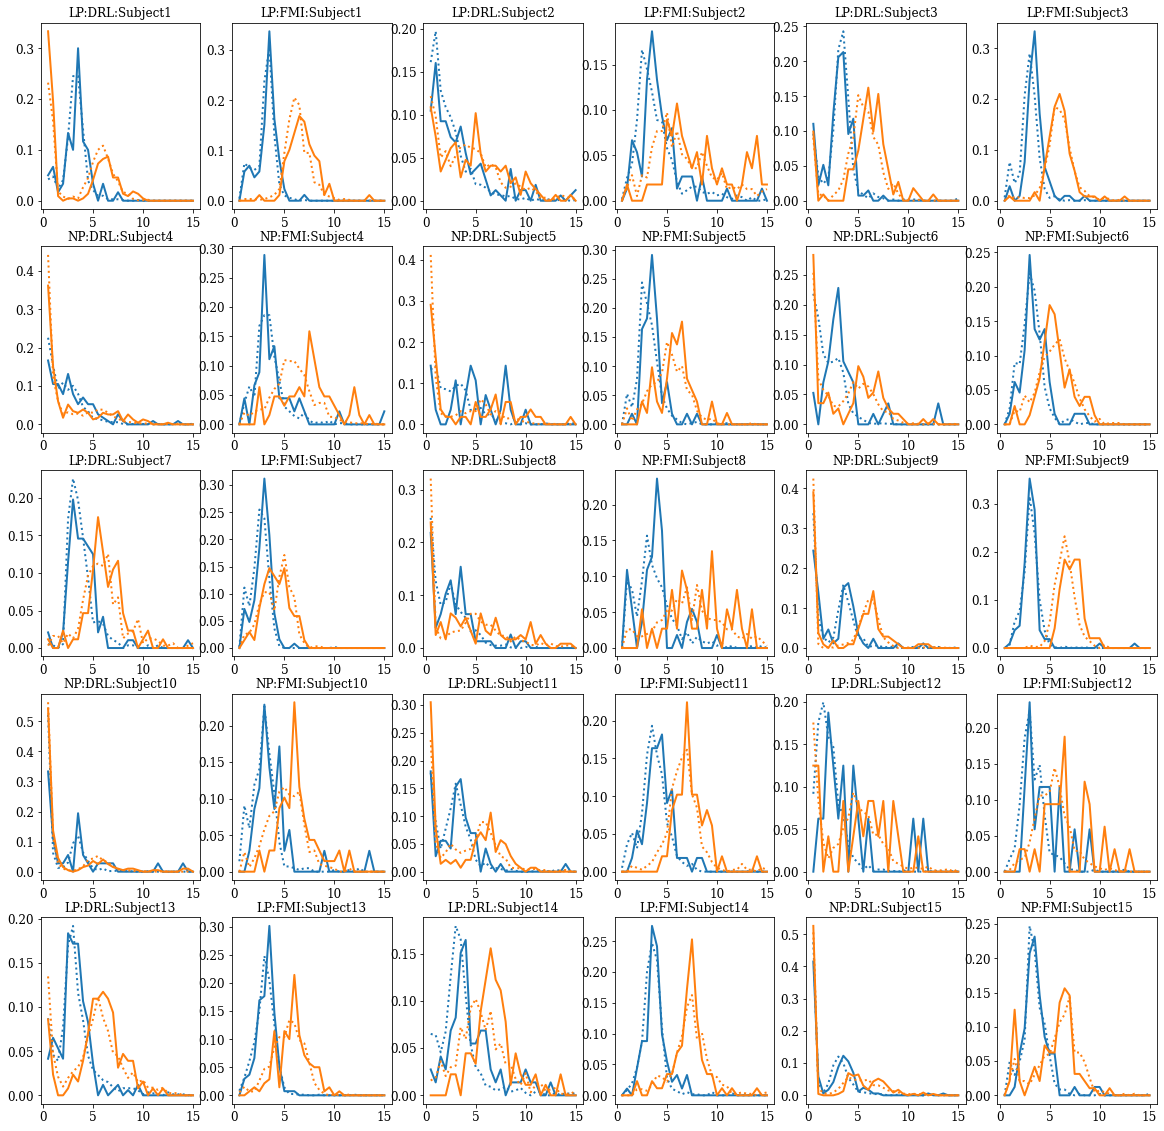

In [71]:
#Column wise group assignment mirroring the data matrices in matlab (setting this up here because it will need to be used throughout the analysis)
colwiseGA = ['LP','LP','LP','NP','NP','NP','LP','NP','NP','NP','LP','LP','LP','LP','NP','NP']
LPindices = [i for i, x in enumerate(colwiseGA) if x == "LP"]
NPindices = [i for i, x in enumerate(colwiseGA) if x == "NP"]
LPindices_mod = np.delete(LPindices,1)
NPindices = np.delete(NPindices,-1)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig1 = plt.figure(figsize=(20,24))
k = 0
for i in range(0,15):
    plt.subplot(6,6,k+1)
    plt.plot(databins[1:len(databins)],E1_DRL_B_3hist[:,i], color = "tab:blue", linestyle = ":", linewidth = 2)
    plt.plot(databins[1:len(databins)],E1_DRL_PF_3hist[:,i], color = "tab:blue", linestyle = "-", linewidth = 2)
    plt.plot(databins[1:len(databins)],E1_DRL_B_6hist[:,i], color = "tab:orange", linestyle = ":", linewidth = 2)
    plt.plot(databins[1:len(databins)],E1_DRL_PF_6hist[:,i], color = "tab:orange", linestyle = "-", linewidth = 2)
    plt.title(colwiseGA[i]+":DRL:Subject"+str(i+1))
    plt.subplot(6,6,k+2)
    plt.plot(databins[1:len(databins)],E1_FMI_B_3hist[:,i], color = "tab:blue", linestyle = ":", linewidth = 2)
    plt.plot(databins[1:len(databins)],E1_FMI_PF_3hist[:,i], color = "tab:blue", linestyle = "-", linewidth = 2)
    plt.plot(databins[1:len(databins)],E1_FMI_B_6hist[:,i], color = "tab:orange", linestyle = ":", linewidth = 2)
    plt.plot(databins[1:len(databins)],E1_FMI_PF_6hist[:,i], color = "tab:orange", linestyle = "-", linewidth = 2)
    plt.title(colwiseGA[i]+":FMI:Subject"+str(i+1))
    k = k + 2




First we need to determine which version of the TR model we should use. The TR model offerred by Watterson et al. (2015) suggest there are only two states: a timing state and a non-timing state. In our expanded TR model (TRe) assumes there are three states: a timing state, a burst-response state, and a lapsed state. 

Thus, we will extract the loglikelihood of our two models across waiting requirements and feeding regimen and select the best model within each schedule. In the approach taken here we want to choose for each schedule (DRL and FMI) within each group of mice the best fitting model that captures behavior under each interval (3 and 6 s) as well as before and during the pre-feeding challenge. 

In [96]:
#Number of free parameters
TR_params = 4 * 4 #num of params in model * number of conditions
TRe_params = 6 * 4 #num of params in model * number of conditions; note this will get multiplied by num of animals when AICc is calculcated

#Amount of data
DRLdata = data_counts[0,:]
FMIdata = data_counts[1,:]

#Preallocate matrix for loglikelihood data
DRL_e1_LLout_TR = np.empty([16,5])
DRL_e1_LLout_TRe = np.empty([16,5])
FMI_e1_LLout_TR = np.empty([16,5])
FMI_e1_LLout_TRe = np.empty([16,5])
#Preallocation matrix for AICc calculation
AICc = np.zeros([2,2])

#Grab Loglikelihood data
DRL_e1_LLout_TR[:,0] = matlab_database['LLcollector_DRL_e1_B3']
DRL_e1_LLout_TR[:,1] = matlab_database['LLcollector_DRL_e1_B6']
DRL_e1_LLout_TR[:,2] = matlab_database['LLcollector_DRL_e1_PF3']
DRL_e1_LLout_TR[:,3] = matlab_database['LLcollector_DRL_e1_PF6']
DRL_e1_LLout_TR[:,4] = np.sum(DRL_e1_LLout_TR[:,0:3],1)


DRL_e1_LLout_TRe[:,0] = matlab_database['LLcollector_DRL_e1_B3_TRe']
DRL_e1_LLout_TRe[:,1] = matlab_database['LLcollector_DRL_e1_B6_TRe']
DRL_e1_LLout_TRe[:,2] = matlab_database['LLcollector_DRL_e1_PF3_TRe']
DRL_e1_LLout_TRe[:,3] = matlab_database['LLcollector_DRL_e1_PF6_TRe']
DRL_e1_LLout_TRe[:,4] = np.sum(DRL_e1_LLout_TRe[:,0:3],1)

FMI_e1_LLout_TR[:,0] = matlab_database['LLcollector_FMI_e1_B3']
FMI_e1_LLout_TR[:,1] = matlab_database['LLcollector_FMI_e1_B6']
FMI_e1_LLout_TR[:,2] = matlab_database['LLcollector_FMI_e1_PF3']
FMI_e1_LLout_TR[:,3] = matlab_database['LLcollector_FMI_e1_PF6']
FMI_e1_LLout_TR[:,4] = np.sum(FMI_e1_LLout_TR[:,0:3],1)

FMI_e1_LLout_TRe[:,0] = matlab_database['LLcollector_FMI_e1_B3_TRe']
FMI_e1_LLout_TRe[:,1] = matlab_database['LLcollector_FMI_e1_B6_TRe']
FMI_e1_LLout_TRe[:,2] = matlab_database['LLcollector_FMI_e1_PF3_TRe']
FMI_e1_LLout_TRe[:,3] = matlab_database['LLcollector_FMI_e1_PF6_TRe']
FMI_e1_LLout_TRe[:,4] = np.sum(FMI_e1_LLout_TRe[:,0:3],1)



#Akaine Information Criterion (corrected)
AICc[0,0] = 2*(TR_params*8)+(-2*np.sum(DRL_e1_LLout_TR[LPindices,4])) + np.divide(2*((TR_params*8)^2)+(2*(TR_params*8)),np.sum(DRLdata[LPindices])-(TR_params*8)-1) #TR Model: LP animals in DRL
AICc[0,1] = 2*(TR_params*8)+(-2*np.sum(DRL_e1_LLout_TRe[LPindices,4])) + np.divide(2*((TR_params*8)^2)+(2*(TR_params*8)),np.sum(DRLdata[LPindices])-(TR_params*8)-1) #TRe Model: LP animals in DRL
AICc[1,0] = 2*(TR_params*8)+(-2*np.sum(DRL_e1_LLout_TR[NPindices,4])) + np.divide(2*((TR_params*8)^2)+(2*(TR_params*8)),np.sum(DRLdata[NPindices])-(TR_params*8)-1) #TR Model: NP animals in DRL
AICc[1,1] = 2*(TR_params*8)+(-2*np.sum(DRL_e1_LLout_TRe[NPindices,4])) + np.divide(2*((TR_params*8)^2)+(2*(TR_params*8)),np.sum(DRLdata[NPindices])-(TR_params*8)-1) #TRe Model: NP animals in DRL

AICc_DRL_dataframe = pd.DataFrame(AICc)
AICc_DRL_dataframe.columns = ["TR","TRe"]
AICc_DRL_dataframe.index = ["LP","NP"]
AICc_DRL_dataframe['minAICmodel'] = str(AICc_DRL_dataframe.idxmin(axis=1)[0])
AICc_DRL_dataframe['deltaAICc'] = AICc_DRL_dataframe.max(axis=1)-AICc_DRL_dataframe.min(axis=1) 

AICc[0,0] = 2*(TR_params*7)+(-2*np.sum(FMI_e1_LLout_TR[LPindices,4])) + np.divide(2*((TR_params*7)^2)+(2*(TR_params*7)),np.sum(DRLdata[LPindices])-(TR_params*7)-1) #TR Model: LP animals in FMI
AICc[0,1] = 2*(TR_params*7)+(-2*np.sum(FMI_e1_LLout_TRe[LPindices,4])) + np.divide(2*((TR_params*7)^2)+(2*(TR_params*7)),np.sum(DRLdata[LPindices])-(TR_params*7)-1) #TRe Model: LP animals in FMI
AICc[1,0] = 2*(TR_params*7)+(-2*np.sum(FMI_e1_LLout_TR[NPindices,4])) + np.divide(2*((TR_params*7)^2)+(2*(TR_params*7)),np.sum(DRLdata[NPindices])-(TR_params*7)-1) #TR Model: NP animals in FMI
AICc[1,1] = 2*(TR_params*7)+(-2*np.sum(FMI_e1_LLout_TRe[NPindices,4])) + np.divide(2*((TR_params*7)^2)+(2*(TR_params*7)),np.sum(DRLdata[NPindices])-(TR_params*7)-1) #TRe Model: NP animals in FMI

AICc_FMI_dataframe = pd.DataFrame(AICc)
AICc_FMI_dataframe.columns = ["TR","TRe"]
AICc_FMI_dataframe.index = ["LP","NP"]
AICc_FMI_dataframe['minAICmodel'] = str(AICc_FMI_dataframe.idxmin(axis=1)[0])
AICc_FMI_dataframe['deltaAICc'] = AICc_FMI_dataframe.max(axis=1)-AICc_FMI_dataframe.min(axis=1) 

display(AICc_DRL_dataframe)

C:\Users\carte\AppData\Local\Temp/ipykernel_6400/228729674.py:55: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  AICc_DRL_dataframe['deltaAICc'] = AICc_DRL_dataframe.max(axis=1)-AICc_DRL_dataframe.min(axis=1)
C:\Users\carte\AppData\Local\Temp/ipykernel_6400/228729674.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  AICc_FMI_dataframe['deltaAICc'] = AICc_FMI_dataframe.max(axis=1)-AICc_FMI_dataframe.min(axis=1)


,TR,TRe,minAICmodel,deltaAICc
LP,30897.216060,30896.764049,TRe,1843.897190
NP,25208.422674,25148.596747,TRe,1846.228943


In [97]:
display(AICc_FMI_dataframe)

,TR,TRe,minAICmodel,deltaAICc
LP,30897.216060,30896.764049,TRe,0.452010
NP,25208.422674,25148.596747,TRe,59.825927


The minimum threshold for accepting a more complex model such as TRe is a delta AICc of 4, which corresponds to the more complex model being e^2 times more likely than the simpler model.  
The TRe model explains the data for LP and NP mice in DRL and NP in FMI.   
Interestingly, the TRe model is not necessary for capturing the data of LP mice in FMI.  
What's more, the degree of evidence for the TRe model in DRL is substantially higher (e^~900) than in FMI (when it was selected, for NP mice, e^~30).  

This suggests at least two preliminary conclusions:
1. Response withholding under DRL less temporally regulated than under FMI
2. The initiation response matters: Response withholding initiated with a nose-poke was less temporally regulated than when initiated by a LP, especially when initiation was of an FMI schedule. 

We now focus our analysis on shared parameters and derived statistics from the gamma distribution. 

Let's start by visualizing fits of the model. 

In [100]:
#Create high rez bins for the fits
fitbins = np.linspace(0,15,31)

#First we need the parameter estimates
DRL_B3_params = matlab_database['pcollector_DRL_e1_B3_TRe']
DRL_PF3_params = matlab_database['pcollector_DRL_e1_PF3_TRe']
DRL_B6_params = matlab_database['pcollector_DRL_e1_B6_TRe']
DRL_PF6_params = matlab_database['pcollector_DRL_e1_PF6_TRe']
visDRL_B3 = np.zeros((fitbins.shape[0]-1,16)) 
visDRL_B6 = np.zeros((fitbins.shape[0]-1,16)) 
visDRL_PF3 = np.zeros((fitbins.shape[0]-1,16)) 
visDRL_PF6 = np.zeros((fitbins.shape[0]-1,16)) 
for i in range(0,16):
    cdf = DRL_B3_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+DRL_B3_params[0,i],0,DRL_B3_params[1,i])+DRL_B3_params[4,i]*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_B3_params[3,i])+(1-DRL_B3_params[4,i]-DRL_B3_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_B3_params[5,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visDRL_B3[:,i] = hist
    
    cdf = DRL_B6_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+DRL_B6_params[0,i],0,DRL_B6_params[1,i])+DRL_B6_params[4,i]*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_B6_params[3,i])+(1-DRL_B6_params[4,i]-DRL_B6_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_B6_params[5,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visDRL_B6[:,i] = hist
    
    cdf = DRL_PF3_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+DRL_PF3_params[0,i],0,DRL_PF3_params[1,i])+DRL_PF3_params[4,i]*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_PF3_params[3,i])+(1-DRL_PF3_params[4,i]-DRL_PF3_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_PF3_params[5,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visDRL_PF3[:,i] = hist
    
    cdf = DRL_PF6_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+DRL_PF6_params[0,i],0,DRL_PF6_params[1,i])+DRL_PF6_params[4,i]*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_PF6_params[3,i])+(1-DRL_PF6_params[4,i]-DRL_PF6_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/DRL_PF6_params[5,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visDRL_PF6[:,i] = hist
    
#First we need the parameter estimates
FMI_B3_params = matlab_database['pcollector_FMI_e1_B3']
FMI_PF3_params = matlab_database['pcollector_FMI_e1_PF3']
FMI_B6_params = matlab_database['pcollector_FMI_e1_B6']
FMI_PF6_params = matlab_database['pcollector_FMI_e1_PF6']
visFMI_B3 = np.zeros((fitbins.shape[0]-1,15)) 
visFMI_B6 = np.zeros((fitbins.shape[0]-1,15)) 
visFMI_PF3 = np.zeros((fitbins.shape[0]-1,15)) 
visFMI_PF6 = np.zeros((fitbins.shape[0]-1,15)) 
for i in range(0,15):
    cdf = FMI_B3_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+FMI_B3_params[0,i],0,FMI_B3_params[1,i])+(1-FMI_B3_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/FMI_B3_params[3,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visFMI_B3[:,i] = hist
    
    cdf = FMI_B6_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+FMI_B6_params[0,i],0,FMI_B6_params[1,i])+(1-FMI_B6_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/FMI_B6_params[3,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visFMI_B6[:,i] = hist
    
    cdf = FMI_PF3_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+FMI_PF3_params[0,i],0,FMI_PF3_params[1,i])+(1-FMI_PF3_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/FMI_PF3_params[3,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visFMI_PF3[:,i] = hist
    
    cdf = FMI_PF6_params[2,i]*gamma.cdf(fitbins[1:len(fitbins)],1+FMI_PF6_params[0,i],0,FMI_PF6_params[1,i])+(1-FMI_PF6_params[2,i])*expon.cdf(fitbins[1:len(fitbins)],0,1/FMI_PF6_params[3,i])
    hist = cdf[0]
    hist = np.append(hist,np.diff(cdf))
    visFMI_PF6[:,i] = hist
    

Now we can visualize the fit of the TR model to the constructed probability functions for each animal

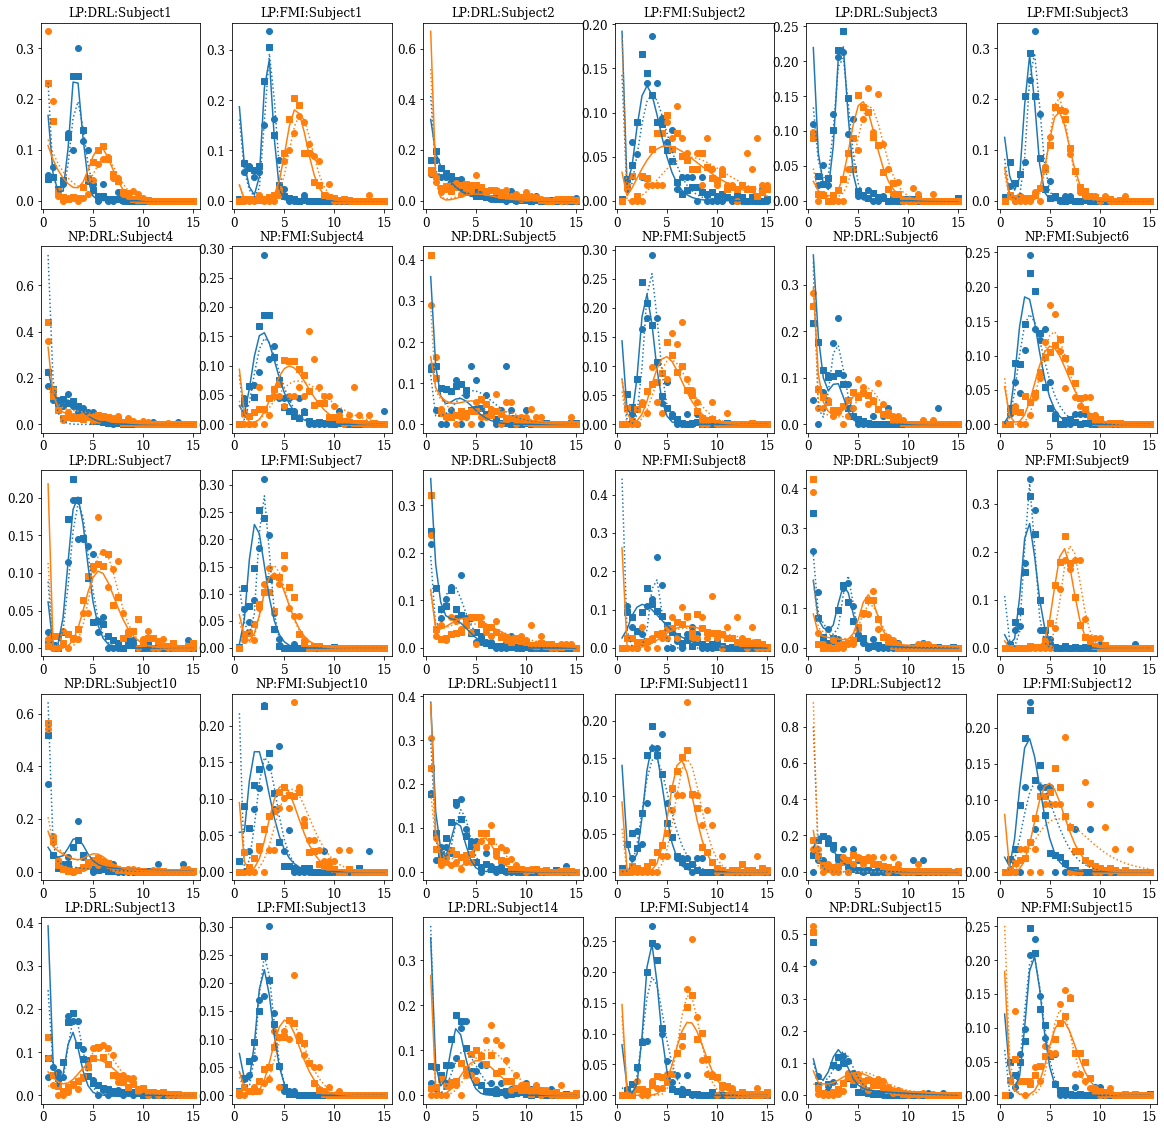

In [105]:

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig1 = plt.figure(figsize=(20,24))
k = 0
for i in range(0,15):
    plt.subplot(6,6,k+1)
    plt.plot(databins[1:len(databins)],E1_DRL_B_3hist[:,i], color = "tab:blue",  marker = "s", linestyle="None")
    plt.plot(databins[1:len(databins)],E1_DRL_PF_3hist[:,i], color = "tab:blue", marker = "o", linestyle="None")
    plt.plot(databins[1:len(databins)],E1_DRL_B_6hist[:,i], color = "tab:orange", marker = "s", linestyle="None")
    plt.plot(databins[1:len(databins)],E1_DRL_PF_6hist[:,i], color = "tab:orange", marker = "o", linestyle="None")
    plt.plot(fitbins[1:len(fitbins)], visDRL_B3[:,i], color = "tab:blue", linestyle="-")
    plt.plot(fitbins[1:len(fitbins)], visDRL_PF3[:,i], color = "tab:blue", linestyle=":")
    plt.plot(fitbins[1:len(fitbins)], visDRL_B6[:,i], color = "tab:orange", linestyle="-")
    plt.plot(fitbins[1:len(fitbins)], visDRL_PF6[:,i], color = "tab:orange", linestyle=":")
    plt.title(colwiseGA[i]+":DRL:Subject"+str(i+1))
    plt.subplot(6,6,k+2)
    plt.plot(databins[1:len(databins)],E1_FMI_B_3hist[:,i], color = "tab:blue", marker="s", linestyle="None")
    plt.plot(databins[1:len(databins)],E1_FMI_PF_3hist[:,i], color = "tab:blue", marker = "o", linestyle="None")
    plt.plot(databins[1:len(databins)],E1_FMI_B_6hist[:,i], color = "tab:orange",  marker="s", linestyle="None")
    plt.plot(databins[1:len(databins)],E1_FMI_PF_6hist[:,i], color = "tab:orange",marker = "o", linestyle="None")
    plt.plot(fitbins[1:len(fitbins)], visFMI_B3[:,i], color = "tab:blue", linestyle="-")
    plt.plot(fitbins[1:len(fitbins)], visFMI_PF3[:,i], color = "tab:blue", linestyle=":")
    plt.plot(fitbins[1:len(fitbins)], visFMI_B6[:,i], color = "tab:orange", linestyle="-")
    plt.plot(fitbins[1:len(fitbins)], visFMI_PF6[:,i], color = "tab:orange", linestyle=":")
    plt.title(colwiseGA[i]+":FMI:Subject"+str(i+1))
    k = k + 2

Now that we've calculated the predicted PDFs we can look at how well it describes the average PDF for each group under each condition.

Text(0.5, 1.0, 'NP FMI')

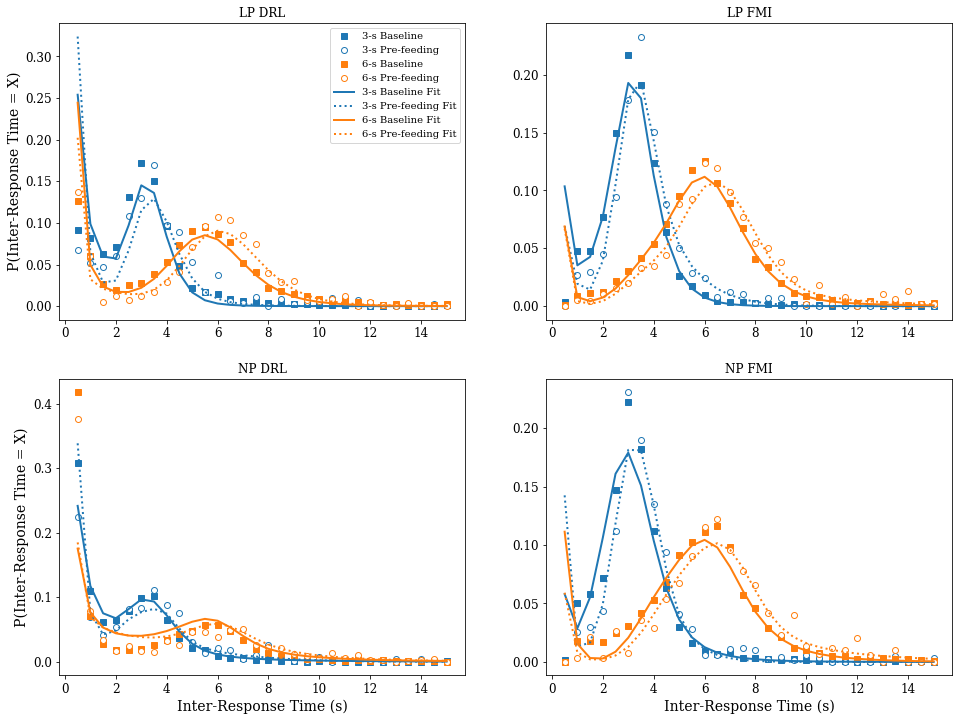

In [106]:
#Sort data
LP_mean_DRL_PDFs = [np.nanmean(E1_DRL_B_3hist[:,LPindices],axis=1),np.nanmean(E1_DRL_PF_3hist[:,LPindices],axis=1),np.nanmean(E1_DRL_B_6hist[:,LPindices],axis=1),np.nanmean(E1_DRL_PF_6hist[:,LPindices_mod],axis=1)]
LP_mean_FMI_PDFs = [np.nanmean(E1_FMI_B_3hist[:,LPindices],axis=1),np.nanmean(E1_FMI_PF_3hist[:,LPindices],axis=1),np.nanmean(E1_FMI_B_6hist[:,LPindices],axis=1),np.nanmean(E1_FMI_PF_6hist[:,LPindices],axis=1)]
LP_mean_DRL_predPDFs = [np.nanmean(visDRL_B3[:,LPindices],axis=1),np.nanmean(visDRL_PF3[:,LPindices],axis=1),np.nanmean(visDRL_B6[:,LPindices],axis=1),np.nanmean(visDRL_PF6[:,LPindices_mod],axis=1)]
LP_mean_FMI_predPDFs = [np.nanmean(visFMI_B3[:,LPindices],axis=1),np.nanmean(visFMI_PF3[:,LPindices],axis=1),np.nanmean(visFMI_B6[:,LPindices],axis=1),np.nanmean(visFMI_PF6[:,LPindices],axis=1)]

NP_mean_DRL_PDFs = [np.nanmean(E1_DRL_B_3hist[:,NPindices],axis=1),np.nanmean(E1_DRL_PF_3hist[:,NPindices],axis=1),np.nanmean(E1_DRL_B_6hist[:,NPindices],axis=1),np.nanmean(E1_DRL_PF_6hist[:,NPindices],axis=1)]
NP_mean_FMI_PDFs = [np.nanmean(E1_FMI_B_3hist[:,NPindices],axis=1),np.nanmean(E1_FMI_PF_3hist[:,NPindices],axis=1),np.nanmean(E1_FMI_B_6hist[:,NPindices],axis=1),np.nanmean(E1_FMI_PF_6hist[:,NPindices],axis=1)]
NP_mean_DRL_predPDFs = [np.nanmean(visDRL_B3[:,NPindices],axis=1),np.nanmean(visDRL_PF3[:,NPindices],axis=1),np.nanmean(visDRL_B6[:,NPindices],axis=1),np.nanmean(visDRL_PF6[:,NPindices],axis=1)]
NP_mean_FMI_predPDFs = [np.nanmean(visFMI_B3[:,NPindices],axis=1),np.nanmean(visFMI_PF3[:,NPindices],axis=1),np.nanmean(visFMI_B6[:,NPindices],axis=1),np.nanmean(visFMI_PF6[:,NPindices],axis=1)]


#Plot data
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
fig2 = plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.plot(databins[1:len(databins)],LP_mean_DRL_PDFs[0], color = "tab:blue", linestyle="None", marker = "s",label = '3-s Baseline')
plt.plot(databins[1:len(databins)],LP_mean_DRL_PDFs[1], color = "tab:blue", linestyle="None", marker = "o",label = '3-s Pre-feeding',markerfacecolor="white",markeredgecolor='tab:blue', markeredgewidth=1)
plt.plot(databins[1:len(databins)],LP_mean_DRL_PDFs[2], color = "tab:orange", linestyle="None", marker = "s",label = '6-s Baseline')
plt.plot(databins[1:len(databins)],LP_mean_DRL_PDFs[3], color = "tab:orange", linestyle="None", marker = "o",label = '6-s Pre-feeding',markerfacecolor="white",markeredgecolor='tab:orange', markeredgewidth=1)
plt.plot(fitbins[1:len(fitbins)],LP_mean_DRL_predPDFs[0], color = "tab:blue", linestyle="-", linewidth=2,label = '3-s Baseline Fit')
plt.plot(fitbins[1:len(fitbins)],LP_mean_DRL_predPDFs[1], color = "tab:blue", linestyle=":", linewidth=2,label = '3-s Pre-feeding Fit')
plt.plot(fitbins[1:len(fitbins)],LP_mean_DRL_predPDFs[2], color = "tab:orange", linestyle="-", linewidth=2,label = '6-s Baseline Fit')
plt.plot(fitbins[1:len(fitbins)],LP_mean_DRL_predPDFs[3], color = "tab:orange", linestyle=":", linewidth=2,label = '6-s Pre-feeding Fit')
plt.title('LP DRL')
plt.legend()

plt.ylabel('P(Inter-Response Time = X)', fontsize = 14)
plt.subplot(2,2,2)
plt.plot(databins[1:len(databins)],LP_mean_FMI_PDFs[0], color = "tab:blue", linestyle="None", marker = "s")
plt.plot(databins[1:len(databins)],LP_mean_FMI_PDFs[1], color = "tab:blue", linestyle="None", marker = "o",markerfacecolor="white",markeredgecolor='tab:blue', markeredgewidth=1)
plt.plot(databins[1:len(databins)],LP_mean_FMI_PDFs[2], color = "tab:orange", linestyle="None", marker = "s")
plt.plot(databins[1:len(databins)],LP_mean_FMI_PDFs[3], color = "tab:orange", linestyle="None", marker = "o",markerfacecolor="white",markeredgecolor='tab:orange', markeredgewidth=1)
plt.plot(fitbins[1:len(fitbins)],LP_mean_FMI_predPDFs[0], color = "tab:blue", linestyle="-", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],LP_mean_FMI_predPDFs[1], color = "tab:blue", linestyle=":", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],LP_mean_FMI_predPDFs[2], color = "tab:orange", linestyle="-", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],LP_mean_FMI_predPDFs[3], color = "tab:orange", linestyle=":", linewidth=2)
plt.title('LP FMI')


plt.subplot(2,2,3)
plt.plot(databins[1:len(databins)],NP_mean_DRL_PDFs[0], color = "tab:blue", linestyle="None", marker = "s")
plt.plot(databins[1:len(databins)],NP_mean_DRL_PDFs[1], color = "tab:blue", linestyle="None", marker = "o",markerfacecolor="white",markeredgecolor='tab:blue', markeredgewidth=1)
plt.plot(databins[1:len(databins)],NP_mean_DRL_PDFs[2], color = "tab:orange", linestyle="None", marker = "s")
plt.plot(databins[1:len(databins)],NP_mean_DRL_PDFs[3], color = "tab:orange", linestyle="None", marker = "o",markerfacecolor="white",markeredgecolor='tab:orange', markeredgewidth=1)
plt.plot(fitbins[1:len(fitbins)],NP_mean_DRL_predPDFs[0], color = "tab:blue", linestyle="-", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],NP_mean_DRL_predPDFs[1], color = "tab:blue", linestyle=":", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],NP_mean_DRL_predPDFs[2], color = "tab:orange", linestyle="-", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],NP_mean_DRL_predPDFs[3], color = "tab:orange", linestyle=":", linewidth=2)
plt.ylabel('P(Inter-Response Time = X)', fontsize = 14)
plt.xlabel('Inter-Response Time (s)', fontsize = 14)
plt.title('NP DRL')


plt.subplot(2,2,4)
plt.plot(databins[1:len(databins)],NP_mean_FMI_PDFs[0], color = "tab:blue", linestyle="None", marker = "s")
plt.plot(databins[1:len(databins)],NP_mean_FMI_PDFs[1], color = "tab:blue", linestyle="None", marker = "o",markerfacecolor="white",markeredgecolor='tab:blue', markeredgewidth=1)
plt.plot(databins[1:len(databins)],NP_mean_FMI_PDFs[2], color = "tab:orange", linestyle="None", marker = "s")
plt.plot(databins[1:len(databins)],NP_mean_FMI_PDFs[3], color = "tab:orange", linestyle="None", marker = "o",markerfacecolor="white",markeredgecolor='tab:orange', markeredgewidth=1)
plt.plot(fitbins[1:len(fitbins)],NP_mean_FMI_predPDFs[0], color = "tab:blue", linestyle="-", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],NP_mean_FMI_predPDFs[1], color = "tab:blue", linestyle=":", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],NP_mean_FMI_predPDFs[2], color = "tab:orange", linestyle="-", linewidth=2)
plt.plot(fitbins[1:len(fitbins)],NP_mean_FMI_predPDFs[3], color = "tab:orange", linestyle=":", linewidth=2)
plt.xlabel('Inter-Response Time (s)', fontsize = 14)
plt.title('NP FMI')



Now that we've visualized the fit of our model let's analyze model parameters and derived statistics. 

First we will analyze parameters common to all groups of mice in all conditions. 
* P = the probability of timing
* q (in TRe) and 1-P (in TR) = the probability of burst responding
* mu = the mean timed response
* sd = variance of timed responses
* cv = sd/mu
* K_burst = the mean burst response time

Then we will analyze parameters common to only mice with the TRe model
* 1-q-P = the probability of lapsed responding
* K_lapse = the mean lapse response time

**STAY TUNED FOR THE NEXT UPDATE**